In [24]:
# Import libraries
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

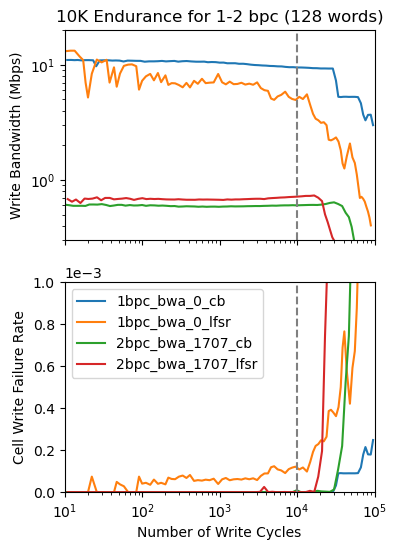

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(4,6), sharex=True)
axs[0].set_title("10K Endurance for 1-2 bpc (128 words)")
axs[0].set_ylabel("Write Bandwidth (Mbps)")
axs[1].set_xlabel("Number of Write Cycles")
axs[1].set_ylabel("Cell Write Failure Rate")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
for fname in sorted(glob.glob("../data/endurance/*_endurance.csv.gz")):
    # Load data
    nrows = 128 if "lfsr" in fname else 127
    ncols = 48 - np.loadtxt("../settings/dead_columns.csv", delimiter=",").size
    data = pd.read_csv(fname, delimiter="\t", names=["t", "successes", "failures", "reads", "sets", "resets", "cycles", "read_bits", "set_bits", "reset_bits", ])
    data = data.drop_duplicates(subset=["successes","failures","cycles"]).reset_index()
    
    # Deal with discontinuities due to multiple measurements
    aliaspts = data[data["cycles"].diff() < 0].index.values
    for aliaspt in aliaspts:
        data.loc[(data.index > aliaspt) & ~data.index.isin(aliaspts-1)] += data.iloc[aliaspt-1]
    data = data[~data.index.isin(aliaspts) & ~data.index.isin(aliaspts-1)]

    # Select points over log space
    data = data.reset_index()
    data = data[data.index.isin(np.logspace(1, 6.2, 100).astype(int))]

    data["bw"] = ncols*data["successes"].diff()/(data["cycles"].diff()*10e-9)
    data["cycle"] = data["successes"]/nrows
    data["wer"] = data["failures"].diff()/data["successes"].diff()/ncols
    data = data[data["cycle"] >= 10]
    data.dropna(inplace=True)

    axs[0].plot(data["cycle"], data["bw"]/1e6, label=fname.split("_endurance")[0].split("/")[-1])
    axs[1].plot(data["cycle"], data["wer"], label=fname.split("_endurance")[0].split("/")[-1])
axs[0].vlines([1e4], ymin=3e-1, ymax=2e1, color="gray", linestyles=["dashed"])
# axs[1].hlines([2e-4], xmin=10, xmax=1e5, color="gray", linestyles=["dashed"])
axs[1].vlines([1e4], ymin=0, ymax=1e-3, color="gray", linestyles=["dashed"])
axs[0].set_xlim(10,1e5)
axs[0].set_ylim(3e-1,2e1)
axs[1].set_xlim(10,1e5)
axs[1].set_ylim(0,1e-3)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[1].legend()
plt.show()